# MNIST Experiments
## Imports

In [88]:
from keras.datasets import mnist
import numpy as np
import torch

from lib.others import build_model
from lib.models import Ganomaly2d
import pandas as pd

from sklearn.pipeline import Pipeline

import lib.transformers as tfs

import seaborn as sns

(train_features, train_labels), (test_features, test_labels) = mnist.load_data()

indices = [index for index, label in enumerate(train_labels) if label == 3]
normal_train = train_features[indices][:400]
normal_test = train_features[indices][:541]

normal_train = normal_train.reshape((-1, 1, 28, 28))
normal_test = normal_test.reshape((-1, 1, 28, 28))

indices = [index for index, label in enumerate(test_labels) if label == 8]
eight_test = test_features[indices][:541]
eight_test = eight_test.reshape((-1, 1, 28, 28))

indices = [index for index, label in enumerate(test_labels) if label == 9]
nine_test = test_features[indices][:541]
nine_test = nine_test.reshape((-1, 1, 28, 28))

indices = [index for index, label in enumerate(test_labels) if label == 1]
one_test = test_features[indices][:541]
one_test = one_test.reshape((-1, 1, 28, 28))

In [91]:
# model settings
n_z = 100
n_channels = 1
n_feature_maps = 32

adversarial_weight = 1
contextual_weight = 1
encoder_weight = 70
lambda_weight = 1/70

# training settings
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
n_gpus = 0
workers = 2
batch_size = 16
max_epochs = 50
lr = 0.0001
beta1 = 0.5
beta2 = 0.999

# extra callbacks
callbacks = []

# run number
run = 1000
verbose = 1

In [92]:
gan_mnist =\
build_model(
    model = Ganomaly2d,
    
    # model parameters
    input_size = 28, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    adversarial_weight = adversarial_weight,
    contextual_weight = contextual_weight, 
    encoder_weight = encoder_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = 0.0001,
    beta1 = 0.5,
    beta2 = 0.999, 
    
    # logging parameters
    suffix = 'stacked_timeseries' + str(run), 
    plot_type = 'lineplot', 
    plot_shape = 3136, 
    plot_latent_shape =600, 
    n_samples = 4,
    
    # extra callbacks
    callbacks = callbacks,
    verbose = verbose
)

In [93]:
pipeline_mnist = \
Pipeline(steps=[
                ('reshaper', tfs.ArrayReshaper((1, 28, 28))),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_mnist)
               ])

In [94]:
pipeline_mnist.fit(normal_train)

  epoch    adversarial_loss    contextual_loss    discriminator_loss    encoder_loss    generator_loss    train_loss     dur
-------  ------------------  -----------------  --------------------  --------------  ----------------  ------------  ------
      1              1.0143            36.4360                0.4219          0.1503           37.6005       38.0224  5.9181
      2              1.3416            36.3808                0.1264          0.0438           37.7662       37.8926  5.8080
      3              1.4288            36.3481                0.0596          0.0271           37.8039       37.8635  7.8496
      4              1.4638            36.3300                0.0349          0.0189           37.8127       37.8476  5.3840
      5              1.4855            36.3169                0.0231          0.0146           37.8169       37.8400  5.2540
      6              1.5043            36.3064                0.0165          0.0120           37.8227       37.8393  5.1155


Pipeline(steps=[('reshaper',
                 <lib.transformers.ArrayReshaper object at 0x000002189BE5F5E0>),
                ('retyper',
                 <lib.transformers.ArrayRetyper object at 0x000002189BE5F070>),
                ('model',
                 <class 'lib.models.GanomalyNet'>[initialized](
  module_=Ganomaly2d(
    (discriminator_loss): BCELoss()
    (contextual_loss): L1Loss()
    (discriminator): DiscriminatorNet2d(
      (features): Sequential(
        (0): Co...
          (pyramid-64-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-64-128-conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (pyramid-128-batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-128-relu): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-128-1-conv): Conv2d(128, 100, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
    )
  ),
))])

In [95]:
normal_results = pipeline_mnist.predict(normal_test)
eight_results = pipeline_mnist.predict(eight_test)
nine_results = pipeline_mnist.predict(nine_test)
one_results = pipeline_mnist.predict(one_test)

In [96]:
results = pd.DataFrame([normal_results, [int(3) for _ in range(541)]]).T
results = results.append(pd.DataFrame([eight_results, [int(8) for _ in range(541)]]).T)
results = results.append(pd.DataFrame([nine_results, [int(9) for _ in range(541)]]).T)
results = results.append(pd.DataFrame([one_results, [int(1) for _ in range(541)]]).T)

results = results.rename({0: 'Anomaly Score', 1: 'Label'}, axis = 1)
results['Label'] = results['Label'].astype(int)

result = results

Text(0.5, 1.0, 'Anomaly Score MNIST')

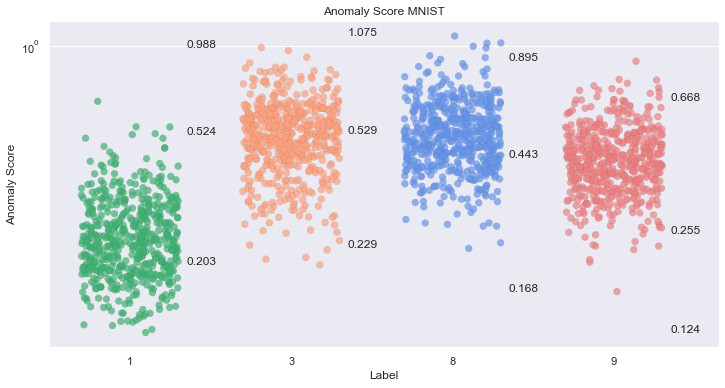

In [97]:

sns.set(rc={'figure.figsize':(12, 6)}, style = 'darkgrid')
fig, ax = plt.subplots()

jitter = 0.3
offset = 0.05

sns.stripplot(data = result, y = 'Anomaly Score', x = 'Label', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = jitter,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

for y, condition in enumerate(result['Label'].unique()):
    condition_results = result[result['Label'] == condition]['Anomaly Score'].astype(np.float32)
    ax.text(y + jitter + offset, condition_results.max(), condition_results.max().round(3))
    ax.text(y + jitter + offset, condition_results.mean(), condition_results.mean().round(3))
    ax.text(y + jitter + offset, condition_results.min(), condition_results.min().round(3))
    
ax.set_xlim(None, y + jitter + offset + 0.3)
    
ax.set_ylabel('Anomaly Score')
ax.set_xlabel('Label')
ax.set_title('Anomaly Score MNIST')

#fig.savefig('data/results/anomaly-score_time-series.png', dpi=330, bbox_inches='tight')